<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/DQN_tutorial_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement learning 실습 #1
- Deep Q-network (DQN)

In [1]:
# 필요한 module들 설치

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!sudo apt-get install xvfb
!pip install xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [2]:
# 패키지 import
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

## DQN model, agent 정의

#### DQN model

In [3]:
# DQN network 모델 정의
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # layer structure는 변경해도 무방: 현재는 [128, 128]의 hidden layer를 가짐
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    # model forwarding
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### DQN agent

In [4]:
# DQN agent 정의
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, \
                 epsilon_decay=0.995, learning_rate=0.001, buffer_size=10000):
        self.q_network = DQN(state_dim, action_dim) # DQN 네트워크
        self.target_network = DQN(state_dim, action_dim) # moving target 문제 완화를 위한 타켓 네트워크 (DQN 네트워크와 동일한 structure)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate) # 네트워크 업데이트 optimaizer (변경가능: ex) rmsprop 등])
        self.criterion = nn.MSELoss() # td target loss function (mean square error)
        self.gamma = gamma # temporal discounted factor
        self.epsilon = epsilon # epsilon greedy parameter
        self.epsilon_decay = epsilon_decay # episode 지남에 따라 epsilon 값 감소 -> exploration 비율 감소

        # Replay buffer
        self.replay_buffer = deque(maxlen=buffer_size) #relay buffer size는 'maxlen' 파라마터 값을 통해 변경

    # action selection
    def select_action(self, state):
        # exploration
        if random.random() < self.epsilon:
            return torch.tensor([[random.randrange(self.q_network.fc2.out_features)]], dtype=torch.long)
        # exploitation
        else:
            with torch.no_grad():
                return self.q_network(state).max(1)[1].view(1, 1) # 각 action에 대한 q 값 중 최대 값을 선택

    # 학습 함수
    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        minibatch = random.sample(self.replay_buffer, batch_size) # batchsize만큼 데이터 sampling
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.cat(states) # 현재 state(s)
        actions = torch.cat(actions) # 현재 action(a)
        rewards = torch.cat(rewards) # (s,a,s')에 대한 reward
        next_states = torch.cat(next_states) # 다음 state(s')
        dones = torch.cat(dones) # episode 종료 :1 else; 0

        q_values = self.q_network(states).gather(1, actions) # 각 action에 대한 q value
        next_q_values = self.target_network(next_states).max(1)[0].view(-1, 1) # td-target 계산을 위한 next q 계산
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values #

        loss = self.criterion(q_values, expected_q_values) # td-error

        # td-error 값에 기반한 네트워크 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # epsilon 값 감소 (매 timestep마다 감소)
        self.epsilon *= self.epsilon_decay

    # target network update
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict()) # 현재 DQN network의 파라미터 복사

In [5]:
# Initialize the environment
env = gym.make('CartPole-v1') # einvironment: cartpole
state_dim = env.observation_space.shape[0] # 4
action_dim = env.action_space.n # 2 (왼쪽, 오른쪽으로 밀기)

#### Hyperparameter 설정

In [6]:
#hyperparameter

## simulation setup
num_episodes = 1000
max_steps = 500

## training hyperparameter
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
learning_rate = 0.001
buffer_size = 1000

agent = DQNAgent(state_dim, action_dim, gamma=gamma, epsilon=epsilon, \
                 epsilon_decay=epsilon_decay, learning_rate=learning_rate, buffer_size=buffer_size)

## DQN 모델 학습

In [8]:
episode_rewards = []
td_errors = []
for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).view(1, -1)
    total_reward = 0

    for step in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor(next_state, dtype=torch.float32).view(1, -1)
        reward = torch.tensor(reward, dtype=torch.float32).view(1, 1)
        done = torch.tensor(done, dtype=torch.float32).view(1, 1)

        agent.replay_buffer.append((state, action, reward, next_state, done))
        agent.train(batch_size)

        total_reward += reward.item()
        state = next_state

        if done:
            break

    episode_rewards.append(total_reward)
    td_errors.append(agent.criterion(agent.q_network(state), agent.target_network(state)).item())

    if episode % 10 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    if episode % 10 == 0:
        agent.update_target_network()

Episode 0/1000, Total Reward: 15.0, Epsilon: 1.0
Episode 10/1000, Total Reward: 23.0, Epsilon: 0.46444185833082485
Episode 20/1000, Total Reward: 13.0, Epsilon: 0.25578670228422234
Episode 30/1000, Total Reward: 12.0, Epsilon: 0.1451730787173275
Episode 40/1000, Total Reward: 16.0, Epsilon: 0.06708733218678724
Episode 50/1000, Total Reward: 25.0, Epsilon: 0.013422995398979608
Episode 60/1000, Total Reward: 19.0, Epsilon: 0.004803756600407726
Episode 70/1000, Total Reward: 30.0, Epsilon: 0.0015090813310791721
Episode 80/1000, Total Reward: 36.0, Epsilon: 0.00026906203525670736
Episode 90/1000, Total Reward: 150.0, Epsilon: 4.4356324676992796e-06
Episode 100/1000, Total Reward: 167.0, Epsilon: 2.506063241334503e-09
Episode 110/1000, Total Reward: 114.0, Epsilon: 1.385245537189208e-11
Episode 120/1000, Total Reward: 133.0, Epsilon: 3.348650450847073e-14
Episode 130/1000, Total Reward: 117.0, Epsilon: 1.2967112607289216e-16
Episode 140/1000, Total Reward: 107.0, Epsilon: 7.167670222045942e

#### Learning curve 확인 (reward, TD-error)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


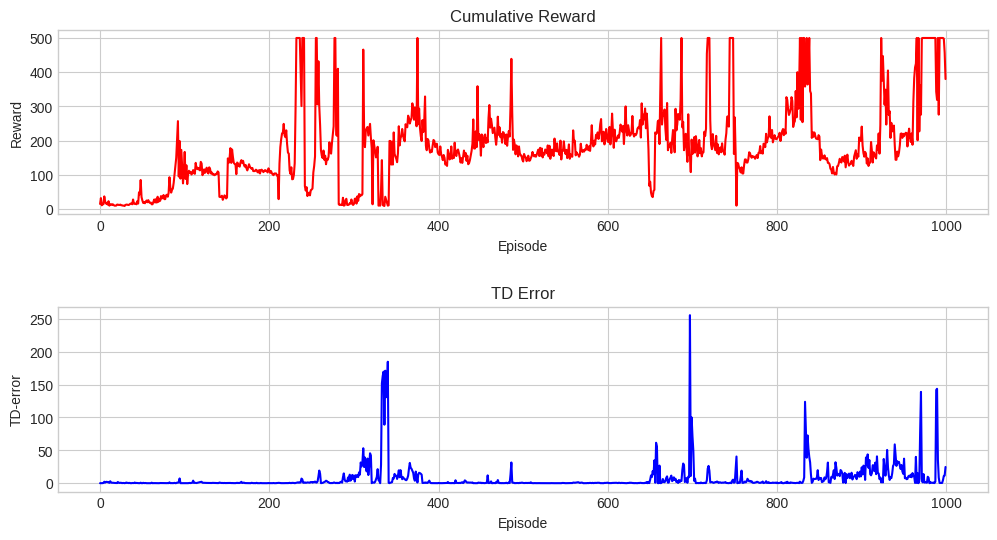

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')

# Plot cumulative reward and TD errors
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards, color='red')
plt.title('Cumulative Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 1, 2)
plt.plot(td_errors, color ='blue')
plt.title('TD Error')
plt.xlabel('Episode')
plt.ylabel('TD-error')

plt.show()

## 학습 모델 execution

In [10]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [11]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [12]:
eval_env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)

state = eval_env.reset()
state = torch.tensor(state, dtype=torch.float32).view(1, -1)
eval_reward = 0
while True:
    eval_env.render()
    #your agent goes here
    action = agent.select_action(state)
    next_state, reward, done, _ = eval_env.step(action.item())
    next_state = torch.tensor(next_state, dtype=torch.float32).view(1, -1)
    reward = torch.tensor(reward, dtype=torch.float32).view(1, 1)
    done = torch.tensor(done, dtype=torch.float32).view(1, 1)

    state = next_state
    eval_reward+= reward.item()
    if done:
      break;

eval_env.close()
show_video()
print('survival time', eval_reward)

survival time 309.0
